In [233]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle
import pandas

with open("2330.pickle",'rb') as f:
    df = pickle.load(f)

In [234]:
df.head()

,adj_close,close,high,low,open,volume,date,year,month,day,week
0,63.50,64.0,64.5,63.5,64.5,18589704,20040211,2004,2,11,2
1,64.00,64.5,65.0,64.0,64.0,48648900,20040212,2004,2,12,3
2,64.00,64.0,64.5,63.5,64.5,28300096,20040213,2004,2,13,4
3,62.50,62.5,64.0,62.5,64.0,43881575,20040216,2004,2,16,0
4,62.50,62.5,63.5,62.5,62.5,31506459,20040217,2004,2,17,1


In [264]:
def normalize(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df = df.drop(['date','adj_close'],axis=1)
    for col in df.columns: 
        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))
    return df
def denormalize(normalized,original,feature='close'):
    original_value = original[feature].values.reshape(-1,1)
    normalized_value = normalized.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    return min_max_scaler.inverse_transform(normalized_value)[:,0]
'''
def normalize(train):
  train = train.drop(["date"], axis=1)
  train = train.drop(["adj_close"], axis=1)
  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return train_norm
'''



'\ndef normalize(train):\n  train = train.drop(["date"], axis=1)\n  train = train.drop(["adj_close"], axis=1)\n  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))\n  return train_norm\n'

In [236]:
def buildTrain(train, pastDay=30, futureDay=5,feature='close'):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay][feature]))
    return np.array(X_train), np.array(Y_train)



In [237]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]


In [238]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

#Y_train = Y_train[:, : ,np.newaxis]
#Y_val = Y_val[:, : ,np.newaxis]
#print(X_train.shape)
##print(Y_train.shape)
#print(X_val.shape)
#print(Y_val.shape)

In [239]:
def buildOneToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
    # output shape: (1, 1)
    model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model
def buildManyToManyModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
    # output shape: (5, 1)
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [331]:
with open("0050.pickle",'rb') as f:
    df = pickle.load(f)
df_norm=normalize(df)
#df_norm=denormalize(df_norm['close'].values[:],df)
X_train, Y_train = buildTrain(df_norm, 30, 1)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
#Y_train = Y_train[:, : ,np.newaxis]
#Y_val = Y_val[:, : ,np.newaxis]

#model = buildOneToOneModel(X_train.shape)
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                800       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 811
Trainable params: 811
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
29/29 [==============================] - 1s 19ms/step - loss: 0.0233 - val_loss: 0.0120
Epoch 2/1000
29/29 [==============================] - 0s 11ms/step - loss: 0.0086 - val_loss: 0.0058
Epoch 3/1000
29/29 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 4/1000
29/29 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 5/1000
29/29 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/1000


29/29 [==============================] - 0s 10ms/step - loss: 1.6162e-04 - val_loss: 1.5481e-04
Epoch 71/1000
29/29 [==============================] - 0s 11ms/step - loss: 1.6016e-04 - val_loss: 1.5414e-04
Epoch 72/1000
29/29 [==============================] - 0s 11ms/step - loss: 1.5526e-04 - val_loss: 1.5378e-04
Epoch 73/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.5492e-04 - val_loss: 1.5224e-04
Epoch 74/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.5409e-04 - val_loss: 1.5007e-04
Epoch 75/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.5308e-04 - val_loss: 1.5100e-04
Epoch 76/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.5489e-04 - val_loss: 1.5428e-04
Epoch 77/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.5440e-04 - val_loss: 1.4880e-04
Epoch 78/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.5056e-04 - val_loss: 1.4727e-04
Epoch 79/1000
29/29 [===

29/29 [==============================] - 0s 11ms/step - loss: 1.1985e-04 - val_loss: 1.1436e-04
Epoch 145/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.1808e-04 - val_loss: 1.1375e-04
Epoch 146/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.2295e-04 - val_loss: 1.4416e-04
Epoch 147/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.2054e-04 - val_loss: 1.1215e-04
Epoch 148/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.2575e-04 - val_loss: 1.1923e-04
Epoch 149/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.2667e-04 - val_loss: 1.1164e-04
Epoch 150/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.2101e-04 - val_loss: 1.1302e-04
Epoch 151/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.1581e-04 - val_loss: 1.1309e-04
Epoch 152/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.1537e-04 - val_loss: 1.1690e-04
Epoch 153/1000
29

29/29 [==============================] - 0s 10ms/step - loss: 1.0871e-04 - val_loss: 9.9461e-05
Epoch 218/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.0277e-04 - val_loss: 1.0135e-04
Epoch 219/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.0487e-04 - val_loss: 1.0485e-04
Epoch 220/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.0345e-04 - val_loss: 1.0223e-04
Epoch 221/1000
29/29 [==============================] - 0s 11ms/step - loss: 1.0263e-04 - val_loss: 1.0155e-04
Epoch 222/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.0248e-04 - val_loss: 9.7348e-05
Epoch 223/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.0345e-04 - val_loss: 9.5675e-05
Epoch 00223: early stopping


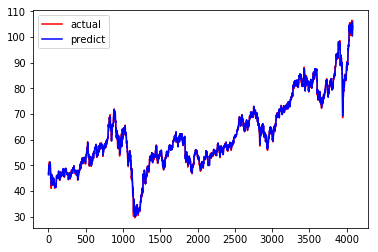

In [332]:
def plot_stock(stock_name,actual,result):

    plt.plot(actual, color='red', label='actual')
    plt.plot(result, color='blue', label='predict')
    plt.legend(loc='best')
    plt.show()
    
df_norm=normalize(df)
X_train, Y_train = buildTrain(df_norm, 30, 1)
result = model.predict(X_train)

result=denormalize(result[:,0],df)
Y_train=denormalize(Y_train[:,0],df)
plot_stock("0050",Y_train,result)

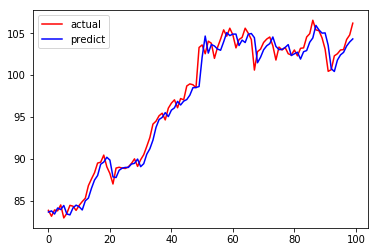

In [333]:
plot_stock("0050",Y_train[-100:],result[-100:])